In [87]:
#import everything needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.signal import find_peaks
from scipy.stats import norm
import scipy.signal
from matplotlib import colors
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from scipy.optimize import curve_fit


In [88]:
#loading the file
file_path = 'output25-55-OR.csv'

#make it a pandas file for easier data analysis
data_all_channels = pd.read_csv(file_path)

#the data is given in 4 channels, and are only interested in channel 1 and channel
data_ch1_unnormalized = data_all_channels.iloc[0::4].reset_index(drop=True)
data_ch2_unnormalized = data_all_channels.iloc[1::4].reset_index(drop=True)
data_ch3_unnormalized = data_all_channels.iloc[2::4].reset_index(drop=True)
data_ch4_unnormalized = data_all_channels.iloc[3::4].reset_index(drop=True)

#we take channel 2 as baseline
data_ch2 = data_ch2_unnormalized 

mean_ch1 = data_ch1_unnormalized.select_dtypes(include='number').values.flatten().mean()
mean_ch2 = data_ch2_unnormalized.select_dtypes(include='number').values.flatten().mean()
mean_ch3 = data_ch3_unnormalized.select_dtypes(include='number').values.flatten().mean()
mean_ch4 = data_ch4_unnormalized.select_dtypes(include='number').values.flatten().mean()

# Determine multipliers to normalize data
mult_ch1 = mean_ch2 / mean_ch1
mult_ch3 = mean_ch2 / mean_ch3
mult_ch4 = mean_ch2 / mean_ch4

print(mult_ch1, mult_ch3, mult_ch4)
#normalize channel 1
data_ch1 = data_ch1_unnormalized.copy()
number_columns = data_ch1.select_dtypes(include='number').columns
data_ch1[number_columns] = data_ch1[number_columns] * mult_ch1 #place here the multiplier to multiplier channel 1

#normalize channel 3
data_ch3 = data_ch3_unnormalized.copy()
number_columns = data_ch3.select_dtypes(include='number').columns
data_ch3[number_columns] = data_ch3[number_columns] *mult_ch3  #place here the multiplier to multiplier channel 3

#normalize channel 4
data_ch4 = data_ch4_unnormalized.copy()
number_columns = data_ch4.select_dtypes(include='number').columns
data_ch4[number_columns] = data_ch4[number_columns] *mult_ch4

0.9825883349333686 1.0594960876133435 1.2422461444946682


In [89]:
#plot pulses to inspect per channel
channels = [data_ch1, data_ch2, data_ch3, data_ch4]
def plot_pulse(row, channel):
    pulse_data = channel.iloc[row, 2:].astype(float)
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(pulse_data)), pulse_data, label="Pulse Data", color="blue")
    plt.title(f"Pulse Data for Row {row}")
    plt.xlabel("Time (arbitrary units)")
    plt.ylabel("Amplitude (mV)")
    plt.legend()
    plt.grid()
    plt.show()

#for i, ch in enumerate(channels, start=1):
    #print(f"Channel {i}")
    #plot_pulse(2, ch)  # Change the row index as needed

In [90]:
def baseline_adjustment(pulse_data, first_samples=200):
    """Provides a baseline adjusted pulse from a given value of first samples, default 50"""
    # calculate the baseline using the specified number of first samples
    baseline_samples = pulse_data[:first_samples]
    baseline_avg = baseline_samples.mean()

    # adjust the pulse to return to zero
    adjusted_pulse = pulse_data - baseline_avg

    return adjusted_pulse

def get_adjusted_pulse(data, row):
    """Get the baseline adjusted pulse for a row"""
    pulse_data = data.iloc[row, 2:].astype(float)

    adjusted_pulse = baseline_adjustment(pulse_data, 50)

    return adjusted_pulse

Channel 1


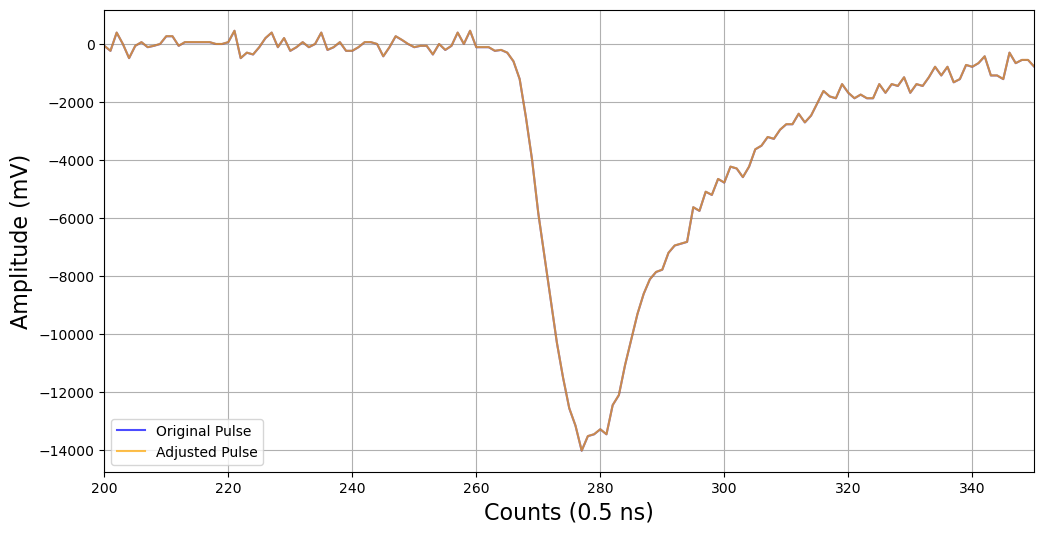

Channel 2


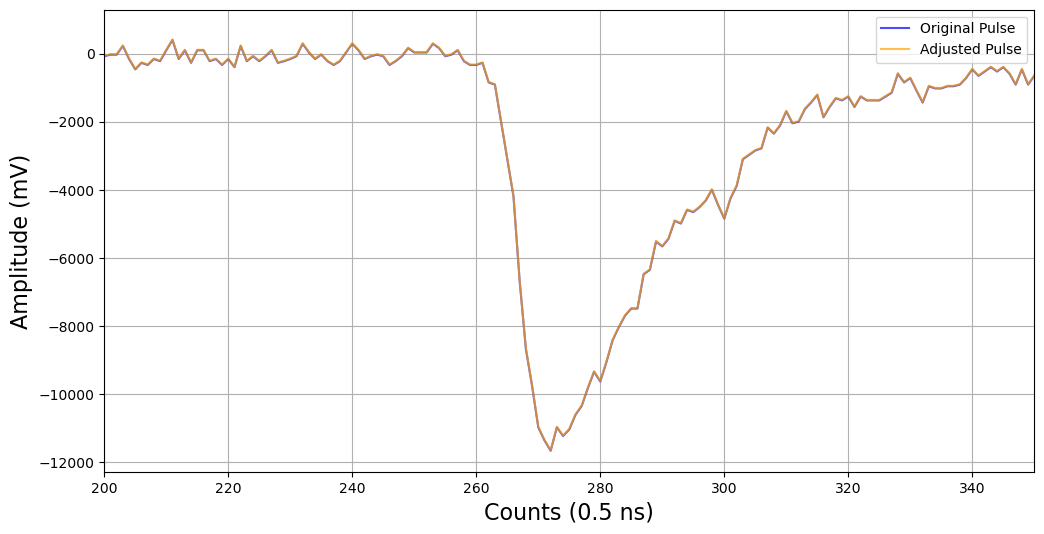

Channel 3


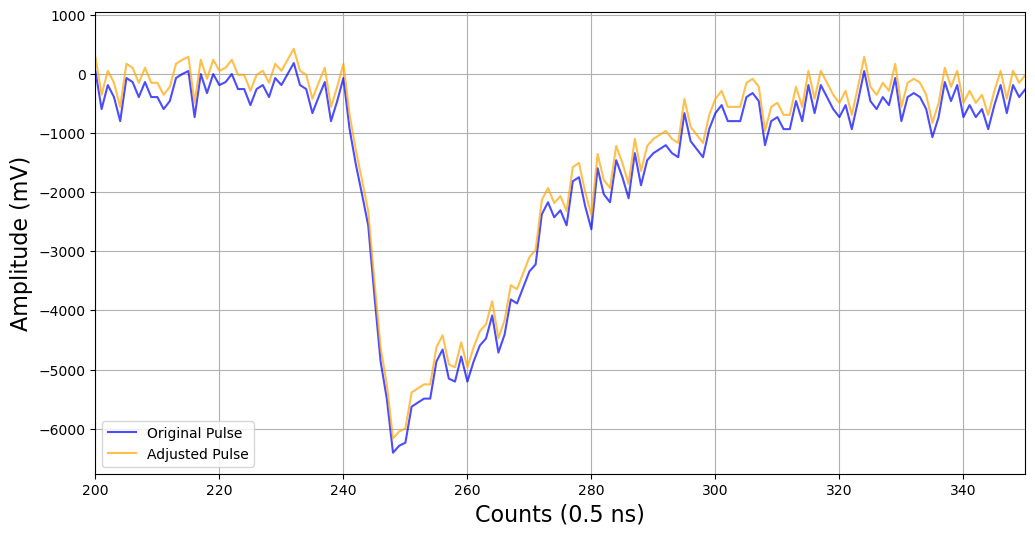

Channel 4


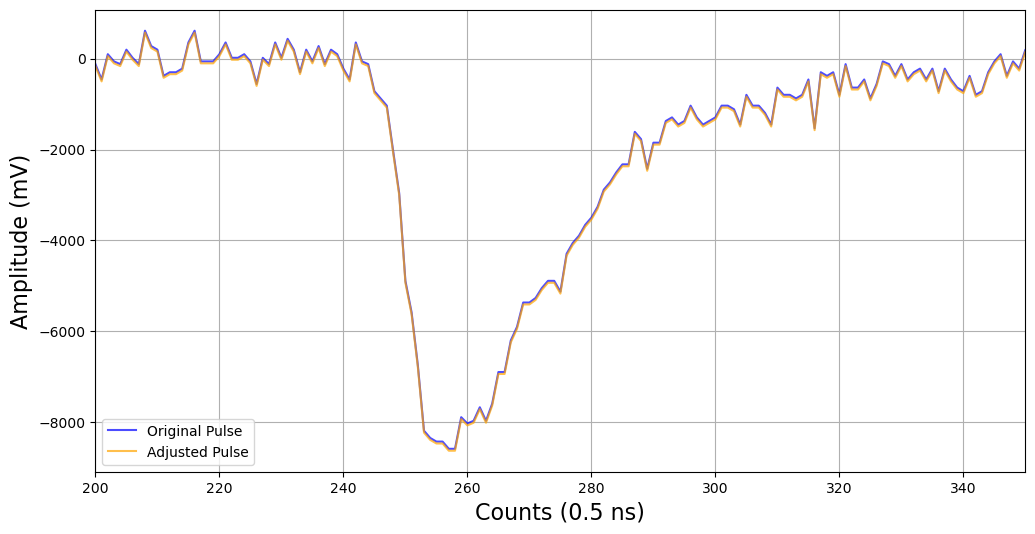

In [125]:
#Plot adjusted pulses
row = 4
for i, ch in enumerate(channels, start=1):
    print(f"Channel {i}") 
    pulse_data = ch.iloc[row, 2:].astype(float) 
    adjusted_pulse = get_adjusted_pulse(ch, row) 
    plt.figure(figsize=(12, 6)) 
    plt.plot(range(len(pulse_data)), pulse_data, label="Original Pulse", alpha=0.7, color="blue")
    plt.plot(range(len(adjusted_pulse)), adjusted_pulse, label="Adjusted Pulse", alpha=0.7, color="orange")
    #plt.title(f"Original and Adjusted Pulse for Channel {i}, Acquisition {row}")
    
    plt.xlabel("Counts (0.5 ns)", fontsize=16)
    plt.ylabel("Amplitude (mV)", fontsize=16)
    plt.xlim(200,350)
    plt.legend()
    plt.grid()
    plt.show()

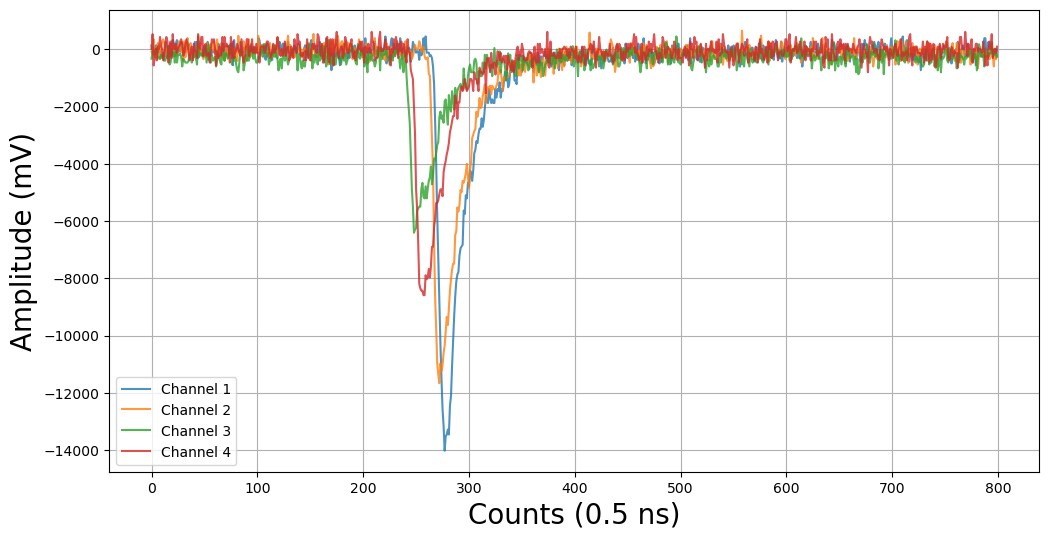

In [92]:
#all pulses in one graph
plt.figure(figsize=(12, 6))

for i, ch in enumerate(channels, start=1):
    pulse_data = ch.iloc[row, 2:].astype(float)
    plt.plot(range(len(pulse_data)), pulse_data, label=f"Channel {i}", alpha=0.8)

#plt.xlim(0,50)
plt.xlabel("Counts (0.5 ns)", fontsize=20)
plt.ylabel("Amplitude (mV)", fontsize=20)
#plt.title("Original Pulses (all channels)", fontsize=14)
plt.legend()
plt.grid()
plt.show()


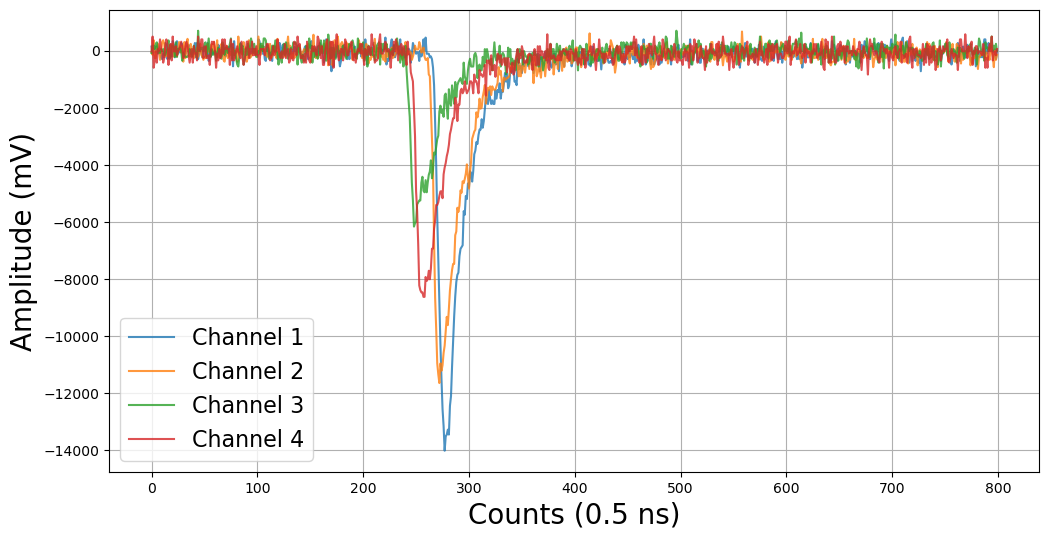

In [93]:
#All adjusted pulses but zoomed in to investage pulses better
plt.figure(figsize=(12, 6))

for i, ch in enumerate(channels, start=1):
    adjusted_pulse = get_adjusted_pulse(ch, row)
    plt.plot(range(len(adjusted_pulse)), adjusted_pulse, label=f"Channel {i}", alpha=0.8)

plt.xlabel("Counts (0.5 ns)", fontsize=20)
plt.ylabel("Amplitude (mV)", fontsize=20)
#plt.title("Adjusted Pulses (all channels)", fontsize=14)
#plt.xlim(200,350)
plt.legend(fontsize =16 )
plt.grid()
plt.show()


In [94]:
#function on how to find the bottom of the pulse
#this function finds the index and value of the minimum point of the pulse
def find_pulse_bottom(pulse_data):
    """Provides the index and value of the minimum point of the pulse"""
    index = np.argmin(pulse_data)
    value = pulse_data.iloc[index]
    top_index = np.argmax(pulse_data)
    return index, value, top_index

    
#function on how to find the integral of the pulse
#this function finds the area of the pulse by determining the zero crossing points
#it does this by looking for the first point above zero on the left and right side of the pulse
#it then takes the 2 points prior and the 2 points after and does a linear interpolation to find the exact zero crossing point
#finally it integrates the pulse between the two zero crossing points and returns the area
def find_baseline_area(pulse_data, bottom_index, threshold=0):
    """"Finds the area of the pulse by determining the zero crossing points"""
    left_index_2 = None
    left_index_3 = None
    right_index_2 = None
    right_index_3 = None

    #start at the peak and do 1 step to the left every time and when the value gets above 0,
    # save the 2 point prior and the 2 points after
    for i in range(bottom_index, -1, -1):
        if pulse_data.iloc[i] > threshold:
            left_index_1 = i - 1
            left_index_2 = i
            left_index_3 = i + 1
            left_index_4 = i + 2
            break

    #start at the peak and do 1 step to the right every time and when the value gets above 0,
    #  save the 2 point prior and the 2 points after
    for j in range(bottom_index, len(pulse_data)):
        if pulse_data.iloc[j] > threshold:
            right_index_1 = j - 2
            right_index_2 = j - 1
            right_index_3 = j
            right_index_4 = j + 1
            break

    #interpolation is only done with the first point before the crossing and the point after the crossing.
    needed_indices = [left_index_2, left_index_3, right_index_2, right_index_3]

    #some pulses do not cross the zero on the right side and we want to filter them out by returning none
    if any(index is None or index < 0 or index >= len(pulse_data) for index in needed_indices):
        return None, None, 0

    # interpolation and determining the zero crossing
    y_left = [pulse_data.iloc[left_index_2], pulse_data.iloc[left_index_3]]
    x_left = [left_index_2, left_index_3]
    a_left, b_left = np.polyfit(x_left, y_left, 1)
    zero_point_left_side = (b_left / -a_left)

    y_right = [pulse_data.iloc[right_index_2], pulse_data.iloc[right_index_3]]
    x_right = [right_index_2, right_index_3]
    a_right, b_right = np.polyfit(x_right, y_right, 1)
    zero_point_right_side = (b_right / -a_right)

    #integral of the pulse
    integrated_part = pulse_data[int(zero_point_left_side):int(zero_point_right_side)]

    #determine the area
    area = np.trapz(integrated_part)
    return zero_point_left_side, zero_point_right_side, area


In [95]:
# Now we can loop over all channels and rows to get the integral results
# We will store the results in a list of dictionaries and then convert it to a DataFrame
pulse_tables_df = {
    "ch1": data_ch1.iloc[:, 2:],
    "ch2": data_ch2.iloc[:, 2:],
    "ch3": data_ch3.iloc[:, 2:],
    "ch4": data_ch4.iloc[:, 2:]
}

all_records = []
integral_results = {}

for ch_name, ch_df in pulse_tables_df.items():
    print(f"(Channel {ch_name})")
    records = []
    for row in range(len(ch_df)):
        pulse = get_adjusted_pulse(ch_df, row=row)
        bottom_index, _, _ = find_pulse_bottom(pulse)
        left, right, area = find_baseline_area(pulse, bottom_index, threshold=0)
        #rise_time = bottom_index - left
        records.append({
            "channel": ch_name,
            "row": row,
            "area": -area,             # keep your sign convention
            "left_zero": left,
            "right_zero": right,
            #"rise_time": rise_time,
            "bottom_index": bottom_index
        })
    integral_results[ch_name] = pd.DataFrame(records)

#print(integral_results["rise_time"])
#rise_time_list = np.asarray(integral_results["rise_time"])
#print(integral_results["ch1"]["bottom_index"])



(Channel ch1)
(Channel ch2)
(Channel ch3)
(Channel ch4)


In [96]:
# Get arrays per channel
pulse_tables = {name: df.values  for name, df in pulse_tables_df.items()}

Channel ch1: Peak at 6.60 nC
Channel ch2: Peak at 5.74 nC
Channel ch3: Peak at 3.17 nC
Channel ch4: Peak at 4.88 nC


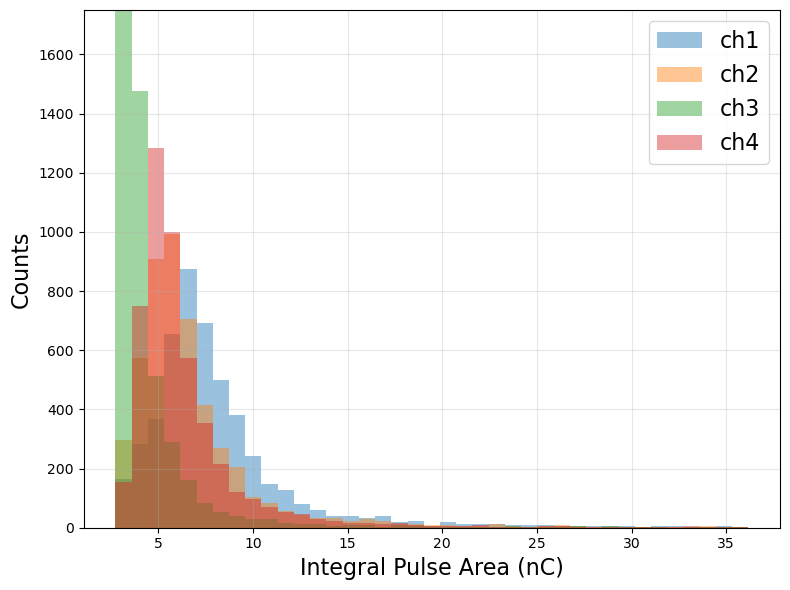

In [97]:
channel_names = ["ch1","ch2", "ch3", "ch4"]
scale = 50000.0
bins = 120 

# areas per channel (absolute in case pulses are negative)
areas = {ch: (np.asarray(integral_results[ch]["area"], float) / scale) for ch in channel_names}
# keep only finite
for ch in channel_names:
    areas[ch] = areas[ch][np.isfinite(areas[ch])]

# common bins from all data (use central percentile range to avoid extreme tails)
all_vals = np.concatenate([areas[ch] for ch in channel_names if areas[ch].size > 0])
lo, hi = np.percentile(all_vals, [1, 99]) if all_vals.size else (0, 1)
bins = np.linspace(lo, hi, 40)  # adjust number of bins if you like

plt.figure(figsize=(8,6))

for ch in channel_names:
    if areas[ch].size:
        counts, bins = np.histogram(areas[ch], bins=bins)
        max_index = np.argmax(counts)
        peak = (bins[max_index] + bins[max_index + 1]) / 2
        print(f"Channel {ch}: Peak at {peak:.2f} nC")
        plt.hist(areas[ch], bins=bins, alpha=0.45, label=ch)  # filled + transparent

plt.ylim(0,1750)
plt.xlabel("Integral Pulse Area (nC)", fontsize=16)
plt.ylabel("Counts", fontsize=16)
#plt.title("Overlaid Histograms of Pulse Integrals (All Channels)", fontsize=13)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()


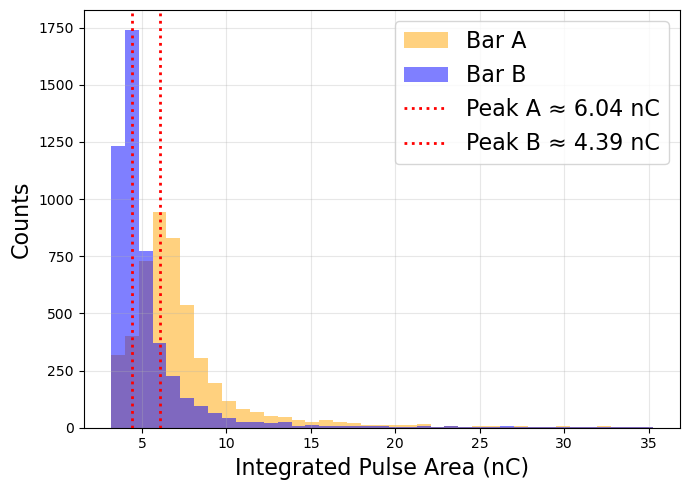

Peak bin center for Bar A: 6.04 nC
Peak bin center for Bar B: 4.39 nC


In [98]:
A1 = np.abs(np.asarray(integral_results["ch1"]["area"], float)) / scale
A2 = np.abs(np.asarray(integral_results["ch2"]["area"], float)) / scale
A3 = np.abs(np.asarray(integral_results["ch3"]["area"], float)) / scale
A4 = np.abs(np.asarray(integral_results["ch4"]["area"], float)) / scale
#geometric mean
GA = np.sqrt(A1 * A2)   # Bar A
GB = np.sqrt(A3 * A4)   # Bar B
GA = GA[np.isfinite(GA)]
GB = GB[np.isfinite(GB)]

# Common bins from combined data
all_vals = np.concatenate([GA, GB])
bins = np.linspace(np.percentile(all_vals, 1), np.percentile(all_vals, 99), 40)

# Compute histogram counts separately
counts_A, _ = np.histogram(GA, bins=bins)
counts_B, _ = np.histogram(GB, bins=bins)

# Find peak bin index for each
peak_idx_A = np.argmax(counts_A)
peak_idx_B = np.argmax(counts_B)

# Compute bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2
peak_center_A = bin_centers[peak_idx_A]
peak_center_B = bin_centers[peak_idx_B]

plt.figure(figsize=(7,5))
plt.hist(GA, bins=bins, alpha=0.5, label="Bar A", color='orange')
plt.hist(GB, bins=bins, alpha=0.5, label="Bar B", color='blue')
plt.axvline(peak_center_A, color='red', linestyle='dotted', linewidth=2, label=f"Peak A ≈ {peak_center_A:.2f} nC")
plt.axvline(peak_center_B, color='red', linestyle='dotted', linewidth=2, label=f"Peak B ≈ {peak_center_B:.2f} nC")
plt.xlabel("Integrated Pulse Area (nC)", fontsize=16)
plt.ylabel("Counts", fontsize=16)
plt.legend(fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print peak bin centers
print(f"Peak bin center for Bar A: {peak_center_A:.2f} nC")
print(f"Peak bin center for Bar B: {peak_center_B:.2f} nC")


In [ ]:
#gain matching
Gain_equalizer = peak_center_A / peak_center_B
print("Gain equalizer (Bar A / Bar B):", Gain_equalizer)


Gain equalizer (Bar A / Bar B): 1.3745741568769863


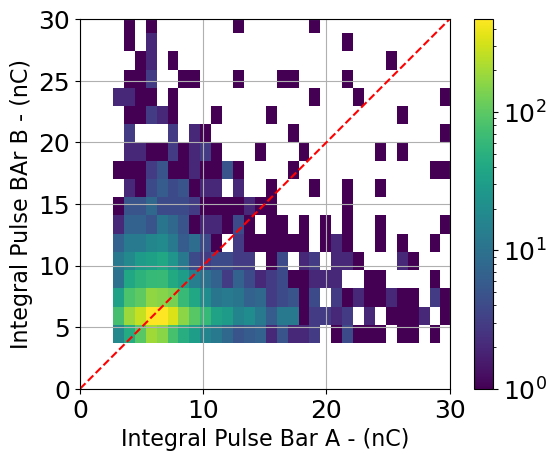

In [100]:
# Define heatmap
heatmap, xedges, yedges = np.histogram2d(GA, GB*Gain_equalizer , bins=100)

# Plot heatmap with logarithmic color scale
img = plt.imshow(
    heatmap.T, 
    origin='lower', 
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
    norm=colors.LogNorm()
)

# Get colorbar and set fontsize of tick labels
cbar = plt.colorbar(img)
cbar.ax.tick_params(labelsize=18) # set fontsize of colorbar ticks

#add labels and give the text a larger fontsize
plt.xlabel(r"Integral Pulse Bar A - (nC)", fontsize=16)
plt.ylabel(r"Integral Pulse BAr B - (nC)", fontsize=16)
plt.tick_params(axis='both', labelsize=18)
plt.grid(True)
ax = plt.gca()
ax.xaxis.offsetText.set_fontsize(18)
ax.yaxis.offsetText.set_fontsize(18)

#plot the red dashed line
plt.plot([0, 2000000], [0, 2000000], color='red', linestyle='--')


# Axes limits
plt.xlim(0, 30)
plt.ylim(0, 30)

plt.show()

peak x position channel 1 = 5.7677
peak x position channel 2 = 5.6018 


In [101]:
def CFD(pulse, delay, multiplier):
    pulse = np.asarray(pulse)
    #add a zero before the code length to delay it
    delayed_pulse = np.concatenate((np.zeros(delay), pulse))
    inverted_pulse = multiplier * pulse
    #also add the zero to the code of the inverted pulse but at the end because otherwise the code is not working
    inverted_pulse_scaled = np.concatenate((inverted_pulse, np.zeros(delay)))
    CFD_pulse = delayed_pulse - inverted_pulse_scaled
    return CFD_pulse

#define the making of the pulse tables
def CFD_table(pulses, delay, multiplier):
    processed_CFD_pulses = []
    #loop over each pulse with respect to the number of the pulse in the set and apply the CFD to all of them
    for i, pulse in enumerate(pulses):
        pulse_array = np.asarray(pulse)
        result = CFD(pulse_array, delay=delay, multiplier=multiplier)
        processed_CFD_pulses.append(result)
        #and ofcourse append them and convert it into a panda dataframe
    final_table = pd.DataFrame(processed_CFD_pulses)
    return final_table

In [102]:
#determined on the bottom of this notebook 
delay = 11
multiplier = 0.35

In [103]:
#define the crossing of the pulses with interpolation
def find_threshold_crossings(pulse_data, bottom_index_local, threshold=0):
    left_index_1 = None
    left_index_2 = None
    left_index_3 = None
    left_index_4 = None
    
    #start at the peak and do 1 step to the left every time and when the value gets above 0, save the 2 point prior and the 2 points after
    for i in range(bottom_index_local, -1, -1):
        if pulse_data.iloc[i] > threshold:
            if i + 2 < len(pulse_data) and i - 1 >= 0:
                left_index_1 = i - 1
                left_index_2 = i
                left_index_3 = i + 1
                left_index_4 = i + 2
                break
            else:
                return None
                
    right_index = None
    #check where it hits the the y=0 axis at the right side of the pulse
    for i in range(bottom_index_local, len(pulse_data)):
        if pulse_data.iloc[i] > threshold:
            right_index = i
            break

    if right_index is None:
        return None 

    #recieve the y values of the x values of the pulses
    left_voltage_1 = pulse_data.iloc[left_index_1]
    left_voltage_2 = pulse_data.iloc[left_index_2]
    left_voltage_3 = pulse_data.iloc[left_index_3]
    left_voltage_4 = pulse_data.iloc[left_index_4]
    right_voltage = pulse_data.iloc[right_index]

    #make a list with the values for interpolation
    x = [left_index_1, left_index_2, left_index_3, left_index_4]
    y = [left_voltage_1, left_voltage_2, left_voltage_3, left_voltage_4]

    #x = [left_index_2, left_index_3]
    #y = [left_voltage_2, left_voltage_3]

    #fit the linear line of best fit
    a, b = np.polyfit(x, y, 1)
    #calculate where it crosses the x-axis
    zero_point = (b / -a)

    #calculate the area
    integrated_part = pulse_data.iloc[left_index_3:right_index + 1]
    area = np.trapz(integrated_part)

    return (left_index_1, left_index_2, left_index_3, left_index_4,
            left_voltage_1, left_voltage_2, left_voltage_3, left_voltage_4, a, b, zero_point, right_index, right_voltage, area)


In [ ]:
#Apply cfd to all data
cfd_tables = {}

for name, df in pulse_tables_df.items():
    print(f"Processing CFD for {name}")
    # df.values gives you a 2D numpy array (rows = pulses, cols = samples)
    cfd_tables[name] = CFD_table(df.values, delay=delay, multiplier=multiplier)

# Example: inspect first rows
#print(len(cfd_tables["ch1"]))
#print(len(cfd_tables["ch4"]))

Processing CFD for ch1
Processing CFD for ch2
Processing CFD for ch3
Processing CFD for ch4
5000
5000


In [105]:
#put all data in dataframe
def process_cfd_table(cfd_data, channel_name):
    records = []

    # Normalize input to 2D: (n_pulses, n_samples)
    if isinstance(cfd_data, pd.DataFrame):
        get_pulse = lambda i: cfd_data.iloc[i]
        n_pulses = len(cfd_data)
    elif isinstance(cfd_data, np.ndarray):
        arr = np.asarray(cfd_data)
        if arr.ndim == 1:
            arr = arr[None, :]
        n_pulses = arr.shape[0]
        get_pulse = lambda i: pd.Series(arr[i]).reset_index(drop=True)
    else:
        raise TypeError(f"Unsupported cfd_data type: {type(cfd_data)}")

    for i in range(n_pulses):
        pulse = get_pulse(i)
        bottom_index_local2, bottom_value, top_index = find_pulse_bottom(pulse)
        result = find_threshold_crossings(pulse, bottom_index_local2, threshold=0)

        # Default values for all fields
        record = {
            "channel": channel_name,
            "pulse_index": i,
            "bottom_index": int(bottom_index_local2),
            "top_index": int(top_index),
            "bottom_value": float(bottom_value),
            "left_cross_index_1": 0,
            "left_cross_index_2": 0,
            "left_cross_index_3": 0,
            "left_cross_index_4": 0,
            "left_cross_value_1": 0.0,
            "left_cross_value_2": 0.0,
            "left_cross_value_3": 0.0,
            "left_cross_value_4": 0.0,
            "right_index": 0,
            "right_voltage": 0.0,
            "a": 0.0,
            "b": 0.0,
            "zero_point": 0.0,
            "area": 0.0,
            "rise_time": abs(int(bottom_index_local2) - int(top_index)),
        }

        if result is not None:
            (left_index_1, left_index_2, left_index_3, left_index_4,
             left_voltage_1, left_voltage_2, left_voltage_3, left_voltage_4,
             a, b, zero_point, right_index, right_voltage, area) = result

            record.update({
                "left_cross_index_1": int(left_index_1),
                "left_cross_index_2": int(left_index_2),
                "left_cross_index_3": int(left_index_3),
                "left_cross_index_4": int(left_index_4),
                "left_cross_value_1": float(left_voltage_1),
                "left_cross_value_2": float(left_voltage_2),
                "left_cross_value_3": float(left_voltage_3),
                "left_cross_value_4": float(left_voltage_4),
                "right_index": int(right_index),
                "right_voltage": float(right_voltage),
                "a": float(a),
                "b": float(b),
                "zero_point": float(zero_point),
                "area": -float(area),
            })

        records.append(record)

    return pd.DataFrame(records)


In [106]:
#final cfd data
cfd_finalized = {}
for name in channel_names:
    print(f"Finalizing CFD features for {name}")
    cfd_finalized[name] = process_cfd_table(cfd_tables[name], channel_name=name)



#print(len(cfd_finalized["ch1"]))
#print(cfd_finalized["ch1"]["area"].head())
#print(cfd_finalized["ch1"]["rise_time"].head())
#cfd_finalized["ch1"] = cfd_finalized["ch1"].drop(1953)
#cfd_finalized["ch2"] = cfd_finalized["ch2"].drop(1953)
#print(len(cfd_finalized["ch1"]))

#print(len(cfd_finalized["ch4"]))

Finalizing CFD features for ch1
Finalizing CFD features for ch2
Finalizing CFD features for ch3
Finalizing CFD features for ch4


In [107]:
dt = 0.5
tbarA_list, tbarB_list = [], []
t1_t2, t3_t4 = [], []

t1 = (cfd_finalized["ch1"]["zero_point"]*dt)-16.33 #cable length correction
t2 = (cfd_finalized["ch2"]["zero_point"]*dt)-16.33
t3 = (cfd_finalized["ch3"]["zero_point"]*dt)-10.66
t4 = (cfd_finalized["ch4"]["zero_point"]*dt)-10.66

for i in range(len(cfd_finalized["ch1"])):
    tbarA_list.append((t1[i] + t2[i]) / 2)
    t1_t2.append(t1[i] - t2[i])
    t3_t4.append(t3[i] - t4[i])
    tbarB_list.append((t3[i] + t4[i]) / 2)


tbarA = np.asarray(tbarA_list, dtype=float)
tbarB = np.asarray(tbarB_list, dtype=float)
t1_t2 = np.asarray(t1_t2, dtype=float)
t3_t4 = np.asarray(t3_t4, dtype=float)
# Pair difference (centered) → timing spread
dt_pair = tbarA - tbarB
print(len(dt_pair))


5000


In [108]:
#sum of two Gaussians scaled to histogram counts
def two_gauss(x, A1, mu1, sig1, A2, mu2, sig2):
    # A's are amplitudes in "counts", so include bin width in scaling
    g1 = A1 * np.exp(-0.5*((x-mu1)/sig1)**2)
    g2 = A2 * np.exp(-0.5*((x-mu2)/sig2)**2)
    return g1 + g2

Fitting 4970 entries after filtering


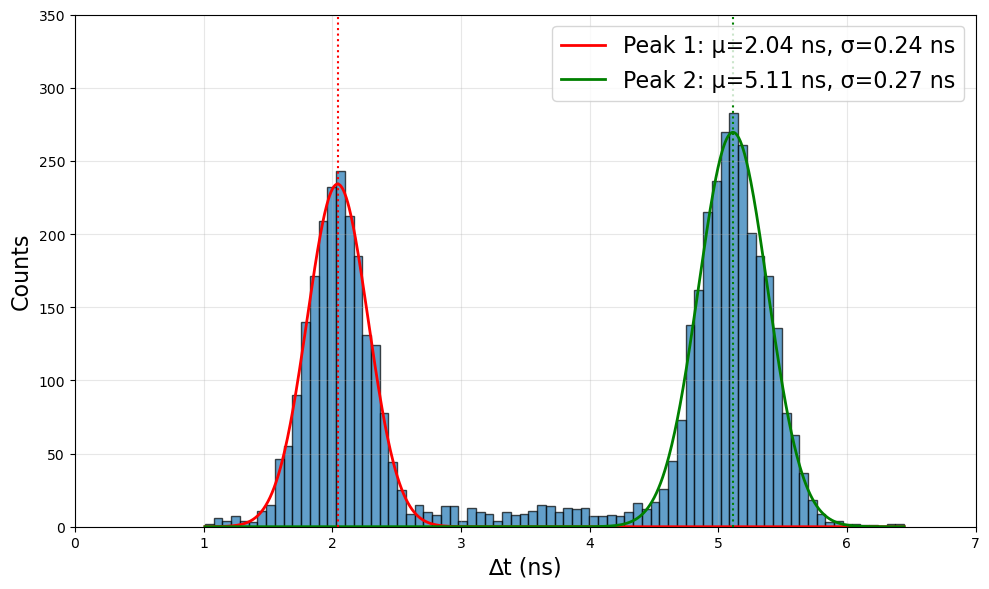

σ_pair: 0.237 ns (left), 0.268 ns (right)
Per-bar σ_t ≈ 0.179 ns


In [126]:
dt_pair = np.asarray(tbarA - tbarB)
#  light outlier guard
dt_pair = dt_pair[(dt_pair > np.percentile(dt_pair, 0.3)) &
                  (dt_pair < np.percentile(dt_pair, 99.7))]


print(f"Fitting {len(dt_pair)} entries after filtering")
# histogram to fit on
bins = 80
counts, edges = np.histogram(dt_pair, bins=bins)
centers = 0.5*(edges[:-1] + edges[1:])
width   = edges[1] - edges[0]

# crude initial guesses from the histogram
i1 = np.argmax(counts)
tmp = counts.copy()
mask = max(1, bins//15)
tmp[max(0, i1-mask):min(bins-1, i1+mask)] = 0
i2 = np.argmax(tmp)

mu1_0, mu2_0 = centers[min(i1,i2)], centers[max(i1,i2)]
A1_0,  A2_0  = counts[i1], counts[i2]
sig0         = 0.3  # ns

p0 = [A1_0, mu1_0, sig0, A2_0, mu2_0, sig0]
xfit = np.linspace(edges[0], edges[-1], 1000)
#fit
popt, pcov = curve_fit(two_gauss, centers, counts, p0=p0, maxfev=20000)
A1, mu1, s1, A2, mu2, s2 = popt

plt.figure(figsize=(10,6))
plt.hist(dt_pair, bins=bins, alpha=0.7, edgecolor="black")

#plt.plot(xfit, two_gauss(xfit, *popt), "k", lw=2, label="Sum fit")
plt.plot(xfit, A1*np.exp(-0.5*((xfit-mu1)/s1)**2), "r", lw=2,
         label=f"Peak 1: μ={mu1:.2f} ns, σ={s1:.2f} ns")
plt.plot(xfit, A2*np.exp(-0.5*((xfit-mu2)/s2)**2), "g", lw=2,
         label=f"Peak 2: μ={mu2:.2f} ns, σ={s2:.2f} ns")
plt.axvline(mu1, color='r', ls=':')
plt.axvline(mu2, color='g', ls=':')

plt.xlabel("∆t (ns)", fontsize=16)
plt.ylabel("Counts", fontsize=16)
#plt.title("Histogram of Pair Time Differences (two-Gaussian fit)", fontsize=18)
plt.xlim(0, 7)
plt.ylim(0,350)
plt.legend(fontsize = 16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


sigma_pair_1 = s1
sigma_pair_2 = s2
# per-bar timing (assume identical bars)
# σ_pair^2 = σ_barA^2 + σ_barB^2 with σ_barA ≈ σ_barB ⇒ σ_bar ≈ σ_pair / √2
sigma_t_bar_A = sigma_pair_1/np.sqrt(2)
sigma_t_bar_B = sigma_pair_2/np.sqrt(2)
sigma_t_bar_mean   = 0.5*(sigma_t_bar_A + sigma_t_bar_B)  # or weighted by peak areas

print(f"σ_pair: {sigma_pair_1:.3f} ns (left), {sigma_pair_2:.3f} ns (right)")
print(f"Per-bar σ_t ≈ {sigma_t_bar_mean:.3f} ns")


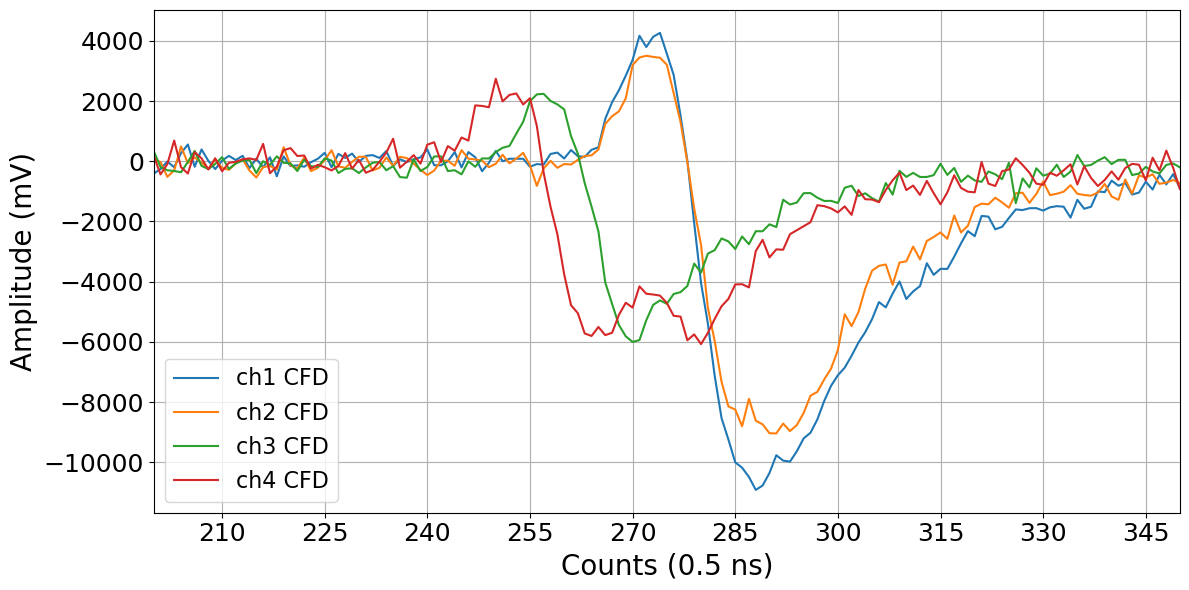

In [110]:
plt.figure(figsize=(12, 6))

for name in channel_names:
    # Extract CFD pulse for the given channel
    cfd_pulse = cfd_tables[name].iloc[row].values

    # Plot CFD pulse
    plt.plot(cfd_pulse, label=f"{name} CFD")


plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.tick_params(axis='both', labelsize=18)
plt.xlabel("Counts (0.5 ns)", fontsize=20)
plt.ylabel("Amplitude (mV)", fontsize=20)
#plt.ylim(-20000, 10000)
plt.xlim(200, 350)
#plt.title(f"Pulse  – CFD Only Across Channels", fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.legend(fontsize=16)
plt.savefig("cfd_all_channels", dpi=300, bbox_inches="tight")
plt.show()


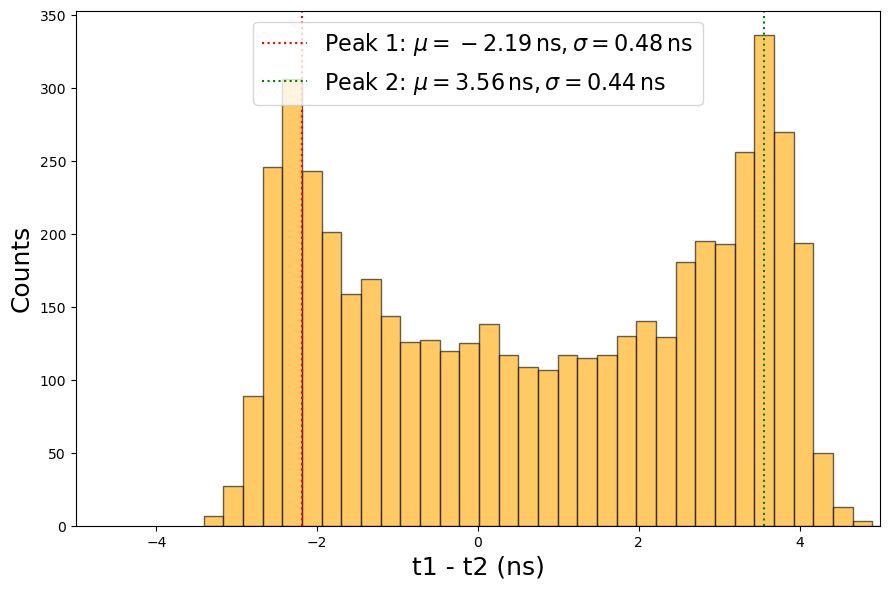

0.43647924206491207
0.4812620459139497


In [ ]:
def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

bins = 500
counts, edges = np.histogram(t1_t2, bins=bins)
bin_centers = 0.5 * (edges[:-1] + edges[1:])
bin_width = edges[1] - edges[0]

#windows to fit
left_min, left_max = -3.0, -1.5
right_min, right_max = 3.0, 4.5

left_mask = (bin_centers >= left_min) & (bin_centers <= left_max)
right_mask = (bin_centers >= right_min) & (bin_centers <= right_max)

#guesses
p0_left  = [counts[left_mask].max(),  -2.2, 0.3]
p0_right = [counts[right_mask].max(),  3.5, 0.3]

#fitting
params_left,  _ = curve_fit(gauss, bin_centers[left_mask],  counts[left_mask],  p0=p0_left)
params_right, _ = curve_fit(gauss, bin_centers[right_mask], counts[right_mask], p0=p0_right)

A_left,  mu_left,  sigma_left  = params_left
A_right, mu_right, sigma_right = params_right


plt.figure(figsize=(9,6))
plt.hist(t1_t2, bins=bins, alpha=0.6, color="orange", edgecolor="black")
plt.xlabel("t1 - t2 (ns)", fontsize=18)
plt.ylabel("Counts", fontsize=18)
plt.xlim(-5, 5)


x_fit_left  = np.linspace(left_min,  left_max,  500)
x_fit_right = np.linspace(right_min, right_max, 500)



plt.axvline(mu_left,  color="red",   linestyle="dotted")
plt.axvline(mu_right, color="green", linestyle="dotted")

label_left  = fr"Peak 1: $\mu={mu_left:.2f} \,\mathrm{{ns}}, \sigma={sigma_left:.2f}\,\mathrm{{ns}}$"
label_right = fr"Peak 2: $\mu={mu_right:.2f} \,\mathrm{{ns}}, \sigma={sigma_right:.2f}\,\mathrm{{ns}}$"

plt.legend( [label_left, label_right], fontsize=16, loc="upper center")
plt.tight_layout()
plt.show()
print(sigma_right)
print(sigma_left)


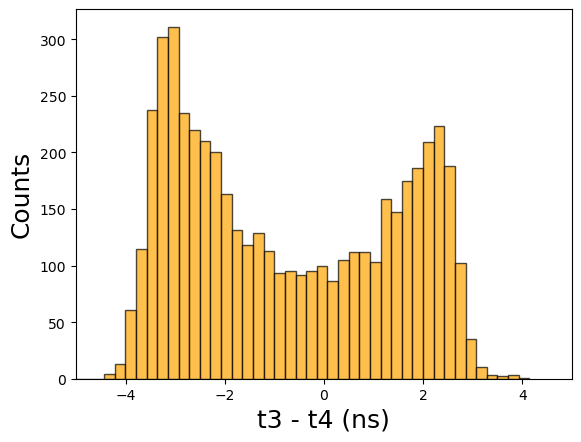

In [ ]:
counts, edges = np.histogram(t3_t4, bins=bins)
bin_centers = 0.5 * (edges[:-1] + edges[1:])
bin_width = edges[1] - edges[0]
plt.hist(t3_t4, bins=bins, alpha=0.7, color="orange", edgecolor="black")
plt.xlabel("t3 - t4 (ns)", fontsize=18)
plt.ylabel("Counts", fontsize=18)
plt.xlim(-5, 5)

plt.show()


In [ ]:
#effective velocity
L = 50 #cm
v = 2*L/(mu_right - mu_left)
print(v)

17.405947659459883


In [124]:
#refractive_index = 1.58  # plastic scintillator

#c = 30  # cm/ns
s = 20  # cm (detector separation)

#v = c / refractive_index  # effective light speed in scintillator (cm/ns)

yA, yB = [], []  # positions and angle

for k in range(len(t1_t2)):
    yA.append((t1_t2[k] * v) / 2)
    yB.append((t3_t4[k] * v) / 2)

sigma_y = v*sigma_t_bar_mean
print(f"spatial resolution = {sigma_y}")

spatial resolution = 3.0980749702955674


In [ ]:
#As cables of bar B are shorter than bar A, B is triggered first. These indices mean that something went wrong in the acquisition
mask_A_first = tbarA < tbarB
indices_Afirst = np.where(mask_A_first)[0]
print(indices_Afirst)

In [117]:
#When A has has higher position, it is hit first as muons come from the sky. It shows that A is hit first more often.

barB_higher_count, barA_higher_count = [],[]

for n in range(len(t1_t2)):
    if yB[n] > yA[n]:
        barB_higher_count.append(n)
    elif yA[n] > yB[n]:
        barA_higher_count.append(n)

print(f"Number of times bar B position is higher than bar A position: {len(barB_higher_count)}")
print(f"Number of times bar A position is higher than bar B position: {len(barA_higher_count)}")

Number of times bar B position is higher than bar A position: 2064
Number of times bar A position is higher than bar B position: 2936


In [118]:
#this block is for debugging the CFD optimizer. The code takes long to run therefore I debugged it with a smaller set of data. Where I would make the data length 100 for example instead of 5000.
cfd_optimizer = {}  # Make sure it's initialized

for name in channel_names:
    cfd_optimizer[name] = []
    for l in range(0, 5000, 1):
        cfd_optimizer[name].append(pulse_tables[name][l])

print(len(cfd_optimizer["ch1"]))

5000


In [119]:
def zero_cross(series):
    """Return zero_point (fractional sample index) using your helpers; None if fail."""
    b, _, _ = find_pulse_bottom(series)
    r = find_threshold_crossings(series, b, threshold=0)
    if (r is None) or (len(r) < 4):
        return None
    # According to your helper's return order, zero_point is r[-4]
    return r[-4]

Completed delay 5
Completed delay 6
Completed delay 7
Completed delay 8
Completed delay 9
Completed delay 10
Completed delay 11
Completed delay 12
Completed delay 13
Completed delay 14
Completed delay 15
Completed delay 16
Completed delay 17
Completed delay 18
Completed delay 19
std: 0.17854090320535168
Best delay: 11
Best fraction: 0.3500000000000001


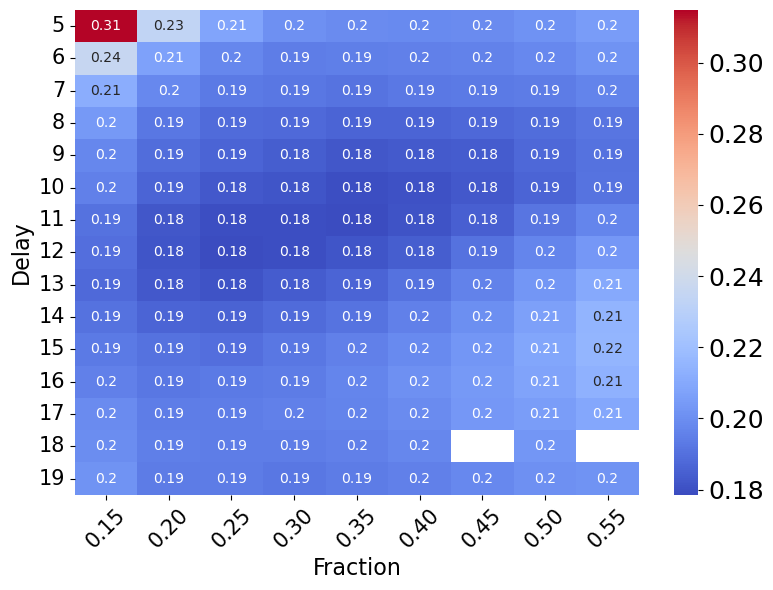

In [120]:
#Code to optimize CFD parameters.
delays = np.arange(5, 20, 1)        # samples
multipliers = np.arange(0.15, 0.60, 0.05)
std_table = []
mu_table = []
for delay in delays:
    std_row = []
    mu_row = []
    for multiplier in multipliers:
        z1_list=[]; z2_list=[]; z3_list=[]; z4_list=[]
        for row_ch1, row_ch2, row_ch3, row_ch4 in zip(cfd_optimizer["ch1"],
                                                    cfd_optimizer["ch2"],
                                                    cfd_optimizer["ch3"],
                                                    cfd_optimizer["ch4"]):
            
            pulse_ch1 = pd.Series(CFD(np.asarray(row_ch1), delay=delay, multiplier=multiplier))
            pulse_ch2 = pd.Series(CFD(np.asarray(row_ch2), delay=delay, multiplier=multiplier))
            pulse_ch3 = pd.Series(CFD(np.asarray(row_ch3), delay=delay, multiplier=multiplier))
            pulse_ch4 = pd.Series(CFD(np.asarray(row_ch4), delay=delay, multiplier=multiplier))

            # Zerocross bepalen
            z1 = zero_cross(pulse_ch1)*dt
            z2 = zero_cross(pulse_ch2)*dt
            z3 = zero_cross(pulse_ch3)*dt
            z4 = zero_cross(pulse_ch4)*dt
            z1_list.append(z1); z2_list.append(z2); z3_list.append(z3); z4_list.append(z4)
            
 
        
        z1 = np.asarray(z1_list); z2 = np.asarray(z2_list); z3 = np.asarray(z3_list); z4 = np.asarray(z4_list)
        #print(dtA_ns)
        
        dt_pair_ns = (((z1 + z2) /2) - ((z3 + z4) /2))   # ns
        dt_pair_ns = dt_pair_ns[np.isfinite(dt_pair_ns)]
        dt_pair_ns = dt_pair_ns[(dt_pair_ns > np.percentile(dt_pair_ns, 0.3)) &
                  (dt_pair_ns < np.percentile(dt_pair_ns, 99.7))]
        bins = 80
        counts, edges = np.histogram(dt_pair_ns, bins=bins)
        centers = 0.5*(edges[:-1] + edges[1:])
        width   = edges[1] - edges[0]

        # crude initial guesses from the histogram
        i1 = np.argmax(counts)
        tmp = counts.copy()
        mask = max(1, bins//15)
        tmp[max(0, i1-mask):min(bins-1, i1+mask)] = 0
        i2 = np.argmax(tmp)

        mu1_0, mu2_0 = centers[min(i1,i2)], centers[max(i1,i2)]
        A1_0,  A2_0  = counts[i1], counts[i2]
        sig0         = 0.3  # ns, rough width guess

        p0 = [A1_0, mu1_0, sig0, A2_0, mu2_0, sig0]
        #print(f"delay={delay}, multiplier={multiplier}, p0={p0}")

        xfit = np.linspace(edges[0], edges[-1], 1000)
        # --- fit ---
        try:
            popt, pcov = curve_fit(two_gauss, centers, counts, p0=p0, maxfev=20000)
            A1, mu1, s1, A2, mu2, s2 = popt
            if s1 <= 0 or s2 <= 0:
                raise ValueError("Negative sigma encountered")
            if (s1/np.sqrt(2) + s2/np.sqrt(2))/2 <0.17:
                raise ValueError("Out of Bounds")
            std_row.append((s1/np.sqrt(2) + s2/np.sqrt(2))/2)  # per-bar σ_t average
            mu_row.append((mu1 + mu2)/2)
        except (RuntimeError, ValueError):
            std_row.append(np.nan)
            mu_row.append(np.nan)
        
    print(f"Completed delay {delay}")
    std_table.append(std_row)
    mu_table.append(mu_row)

#place them in a nice table
panda_std_table = pd.DataFrame(std_table, index=delays, columns=multipliers)
panda_mu_table = pd.DataFrame(mu_table, index=delays, columns=multipliers)

#finding the minimal std function and the given delay and multiplier
min_value_std = panda_std_table.min().min()
min_pos_std = panda_std_table.stack().idxmin()
best_delay_std, best_multiplier_std = min_pos_std
#printing the results
print("std:", min_value_std)
print("Best delay:", best_delay_std)
print("Best fraction:", best_multiplier_std)
plt.figure(figsize=(8, 6))
ax = sns.heatmap(panda_std_table, annot=True, cmap='coolwarm')

# Format x-axis tick labels to two decimals
ax.set_xlabel("Fraction", fontsize=16)
ax.set_ylabel("Delay", fontsize=16)

# Force draw to populate tick labels
plt.draw()

xlabels = [f"{float(label.get_text()):.2f}" for label in ax.get_xticklabels()]
ax.set_xticklabels(xlabels, rotation=45, fontsize=15)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=15)

# Format colorbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)

#plt.title("Heatmap of STD in ns", fontsize=18)
plt.tight_layout()
plt.show()


# Vanaf hier niet nodig